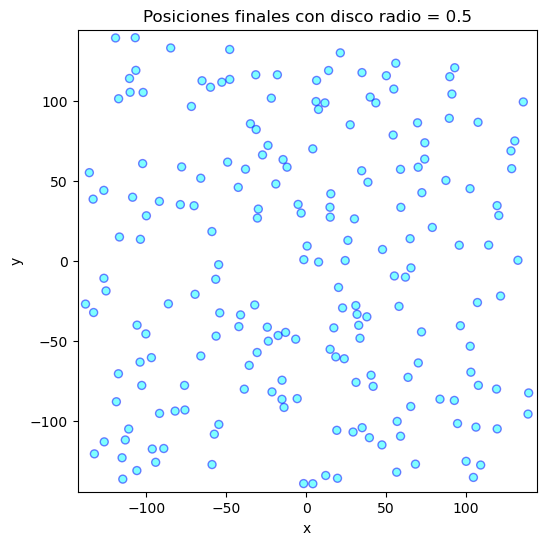

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Cargar datos (omite comentarios)
data = np.loadtxt("trajectories.txt")

num_cols = data.shape[1] - 1
num_particles = num_cols // 2

# Tomamos el último paso para dibujar las posiciones actuales
x_last = data[-1, 1::2]
y_last = data[-1, 2::2]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

radius = 2.5

# Dibujar círculos para todas las partículas en la última posición
for i in range(num_particles):
    circ = Circle((x_last[i], y_last[i]), radius=radius, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(circ)

# Ajustar límites (puedes cambiar según el tamaño del sistema)
xmin, xmax = np.min(x_last) - radius*2, np.max(x_last) + radius*2
ymin, ymax = np.min(y_last) - radius*2, np.max(y_last) + radius*2
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.title("Posiciones finales con disco radio = 0.5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# MSD

δ = 0.001, D = 4.307627e-08 +/- 1.272452e-08
δ = 0.003, D = 3.770677e-07 +/- 1.146762e-07
δ = 0.010, D = 4.200176e-06 +/- 1.287249e-06
δ = 0.030, D = 3.758371e-05 +/- 1.153986e-05
δ = 0.100, D = 4.179603e-04 +/- 1.280689e-04
δ = 0.300, D = 3.488241e-03 +/- 1.046986e-03
Fit results: alpha = 1.987 +/- 0.005, A = 0.03933


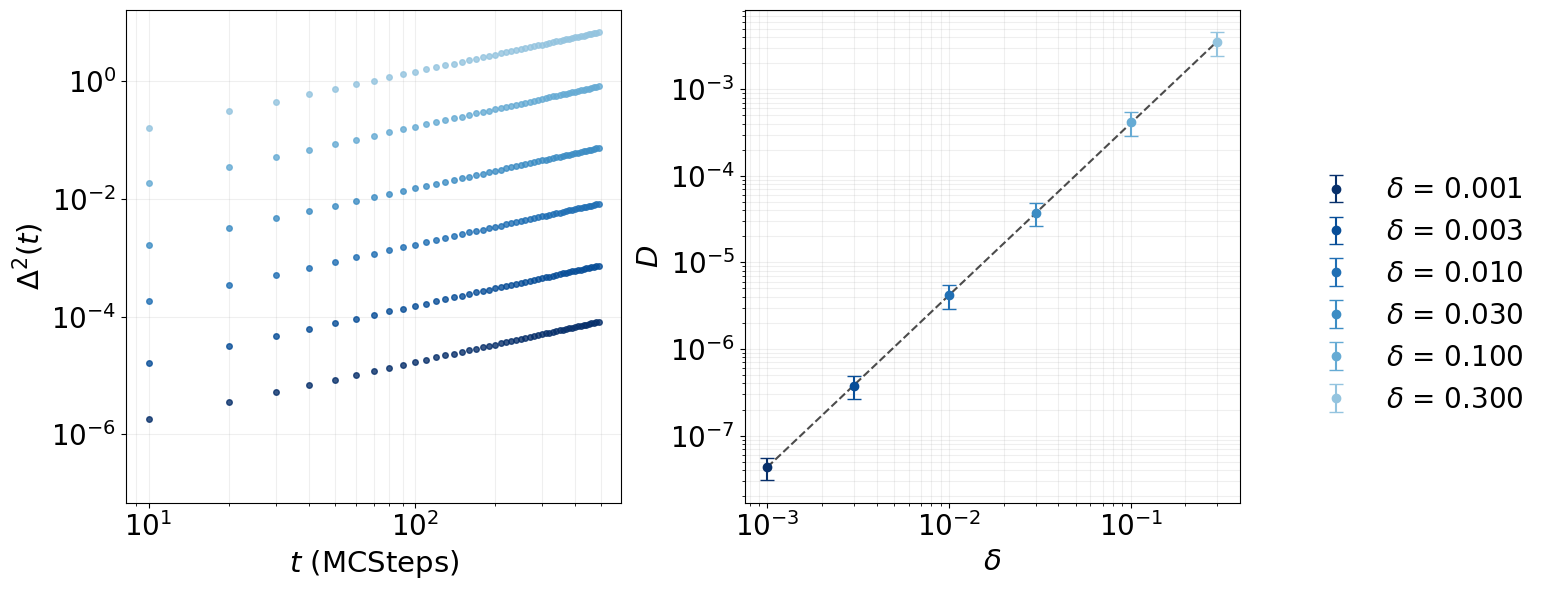

Análisis completado. Gráfico guardado como 'msd_combined_plot_darkblue.png'
1.9865920610590395
0.03932835840028467


In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.optimize import curve_fit

# --- Funciones --- #
def read_msd_data(filenames):
    data = {}
    
    if filenames and not os.path.exists(filenames[0]):
        all_deltas = [float(f.split('_')[-1].replace('.txt', '')) for f in filenames]
        generate_mock_data(all_deltas)
        
    for filename in filenames:
        try:
            delta = float(filename.split('_')[-1].replace('.txt', ''))
        except (IOError, ValueError):
            print(f"No se pudo procesar el archivo: {filename}")
            continue
            
        t = []
        msd = []
        try:
            with open(filename, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 3:
                            t.append(float(parts[1]))
                            msd.append(float(parts[2]))
            
            if t and msd:
                data[delta] = {'t': np.array(t), 'msd': np.array(msd)}
            
        except FileNotFoundError:
            print(f"Archivo no encontrado: {filename}")
        except Exception as e:
            print(f"Error leyendo {filename}: {e}")
            
    return data

def linear_func(t, D):
    return 4 * D * t  # MSD en 2D

# --- Configuración Principal --- #
deltas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
filenames = [f"msd_delta_{delta:.3f}.txt" for delta in deltas]

data = read_msd_data(filenames)
if not data:
    print("No se cargaron datos. Saliendo.")
    exit()

# --- Paleta de colores en tonos azules oscuros --- #
norm = mcolors.LogNorm(vmin=min(deltas), vmax=max(deltas))
cmap = cm.Blues_r  # Invertimos para que deltas pequeños sean oscuros

def get_dark_color(delta, cmap, norm, min_val=0.0, max_val=0.6):
    """
    Retorna un color azul oscuro evitando tonos muy claros.
    """
    color_val = min_val + (norm(delta) * (max_val - min_val))
    return cmap(color_val)

# --- Crear figura --- #
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- MSD vs t --- #
for delta in sorted(data.keys()):
    t = data[delta]['t']
    msd = data[delta]['msd']
    color = get_dark_color(delta, cmap, norm)
    ax1.loglog(t, msd, 'o', color=color, markersize=4, alpha=0.8)

ax1.set_xlabel('$t$ (MCSteps)', fontsize=21)
ax1.set_ylabel('$\Delta^2(t)$', fontsize=21)
ax1.tick_params(axis='both', labelsize=20)
ax1.grid(True, which="both", ls="-", alpha=0.2)

# --- Difusividad D con barras de error reales --- #
D_values = []
delta_values = []
D_errors = []

for delta in sorted(data.keys()):
    t = data[delta]['t']
    msd = data[delta]['msd']
    
    if len(t) > 10:
        start_idx = len(t) // 3
        t_fit = t[start_idx:]
        msd_fit = msd[start_idx:]
        
        try:
            # Ajuste lineal
            popt, _ = curve_fit(linear_func, t_fit, msd_fit, p0=[0.1], bounds=(0, np.inf))
            D = popt[0]
            
            # Desviación estándar de MSD y propagación a D
            msd_std = np.std(msd_fit, ddof=1)
            t_mean = np.mean(t_fit)
            D_err = msd_std / (4 * t_mean)
            
            D_values.append(D)
            delta_values.append(delta)
            D_errors.append(D_err)
            
            print(f"δ = {delta:.3f}, D = {D:.6e} +/- {D_err:.6e}")
        except Exception as e:
            print(f"No se pudo ajustar para δ = {delta}: {e}")
            continue

# --- Plot D vs δ --- #
for i, delta in enumerate(delta_values):
    color = get_dark_color(delta_values[i], cmap, norm)
    ax2.errorbar(delta, D_values[i], yerr=D_errors[i], fmt='o', color=color, 
                 capsize=5, label=f'$\delta$ = {delta:.3f}')

# Ajuste de ley de potencia D = A * delta^alpha
# Ajuste de ley de potencia D = A * delta^alpha con error de alpha
if delta_values and D_values:
    log_deltas = np.log10(delta_values)
    log_Ds = np.log10(D_values)
    
    # Ajuste lineal en log-log con covarianza
    coeffs, cov = np.polyfit(log_deltas, log_Ds, 1, cov=True)
    alpha = coeffs[0]
    log_A = coeffs[1]
    alpha_err = np.sqrt(cov[0,0])  # error estándar de la pendiente
    A = 10**log_A
    
    fit_deltas = np.array(delta_values)
    fit_D = A * (fit_deltas**alpha)
    ax2.plot(fit_deltas, fit_D, 'k--', alpha=0.7)

    print(f"Fit results: alpha = {alpha:.3f} +/- {alpha_err:.3f}, A = {A:.5f}")


ax2.set_xlabel('$\delta$', fontsize=21)
ax2.set_ylabel('$D$', fontsize=21)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid(True, which="both", ls="-", alpha=0.2)

# Leyenda fuera de los ejes
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.92, 0.5), frameon=False, fontsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('msd_combined_plot_darkblue.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar resultados
try:
    with open('difusividad_results_con_error.txt', 'w') as f:
        f.write("# delta\tD\tD_error\n")
        for i in range(len(delta_values)):
            f.write(f"{delta_values[i]}\t{D_values[i]}\t{D_errors[i]}\n")
except Exception as e:
    print(f"No se pudo guardar el archivo de resultados: {e}")

print("Análisis completado. Gráfico guardado como 'msd_combined_plot_darkblue.png'")
print(alpha)
print(A)


## 2.


In [30]:
import numpy as np
from numba import njit

N = 1000
sigma = 1.0
delta = 0.3
N_MC_STEPS = 10000
phis = [0.05, 0.2, 0.5]
snapshot_steps = [1, 500, 1000]

@njit
def triangular_lattice(N, L):
    a = np.sqrt((2.0 * (L**2) / N) / np.sqrt(3))
    dy = a * np.sqrt(3) / 2.0
    ncols = int(np.floor(L / a))
    ncols = max(ncols, 1)
    nrows = int(np.ceil(N / ncols))

    x = np.empty(N)
    y = np.empty(N)
    count = 0
    for row in range(nrows):
        shift = 0.5 * a if row % 2 == 1 else 0.0
        for col in range(ncols):
            if count >= N:
                break
            x[count] = (col - (ncols-1)/2.0)*a + shift
            y[count] = (row - (nrows-1)/2.0)*dy
            count += 1
    return x, y

@njit
def dist_pbc(dx, L):
    return dx - L*np.round(dx / L)

@njit
def trial_move(x, y, L, delta, sigma, N):
    i = np.random.randint(0, N)
    dx = (np.random.rand() - 0.5) * delta
    dy = (np.random.rand() - 0.5) * delta
    new_x = x[i] + dx
    new_y = y[i] + dy
    new_x = new_x - L*np.floor(new_x / L + 0.5)
    new_y = new_y - L*np.floor(new_y / L + 0.5)
    
    for j in range(N):
        if j == i:
            continue
        dx_ij = dist_pbc(new_x - x[j], L)
        dy_ij = dist_pbc(new_y - y[j], L)
        if dx_ij**2 + dy_ij**2 < sigma**2:
            return 0
    x[i] = new_x
    y[i] = new_y
    return 1

# ---------------------------
# LOOP PRINCIPAL
# ---------------------------
for phi in phis:
    area_particle = np.pi * (sigma/2.0)**2
    L = np.sqrt(N * area_particle / phi)
    print(f"Running phi={phi}, box L={L:.3f}")

    x, y = triangular_lattice(N, L)
    
    step_index = 0
    for step in range(N_MC_STEPS):
        for _ in range(N):
            trial_move(x, y, L, delta, sigma, N)
        
        if step_index < len(snapshot_steps) and step+1 == snapshot_steps[step_index]:
            filename = f"snapshot_phi_{phi:.2f}_step_{snapshot_steps[step_index]}.txt"
            np.savetxt(filename, np.column_stack([x, y]))
            print(f"Saved snapshot at step {snapshot_steps[step_index]} for phi={phi}")
            step_index += 1

print("All snapshots generated.")


Running phi=0.05, box L=125.331
Saved snapshot at step 1 for phi=0.05
Saved snapshot at step 500 for phi=0.05
Saved snapshot at step 1000 for phi=0.05
Running phi=0.2, box L=62.666
Saved snapshot at step 1 for phi=0.2
Saved snapshot at step 500 for phi=0.2
Saved snapshot at step 1000 for phi=0.2
Running phi=0.5, box L=39.633
Saved snapshot at step 1 for phi=0.5
Saved snapshot at step 500 for phi=0.5
Saved snapshot at step 1000 for phi=0.5
All snapshots generated.


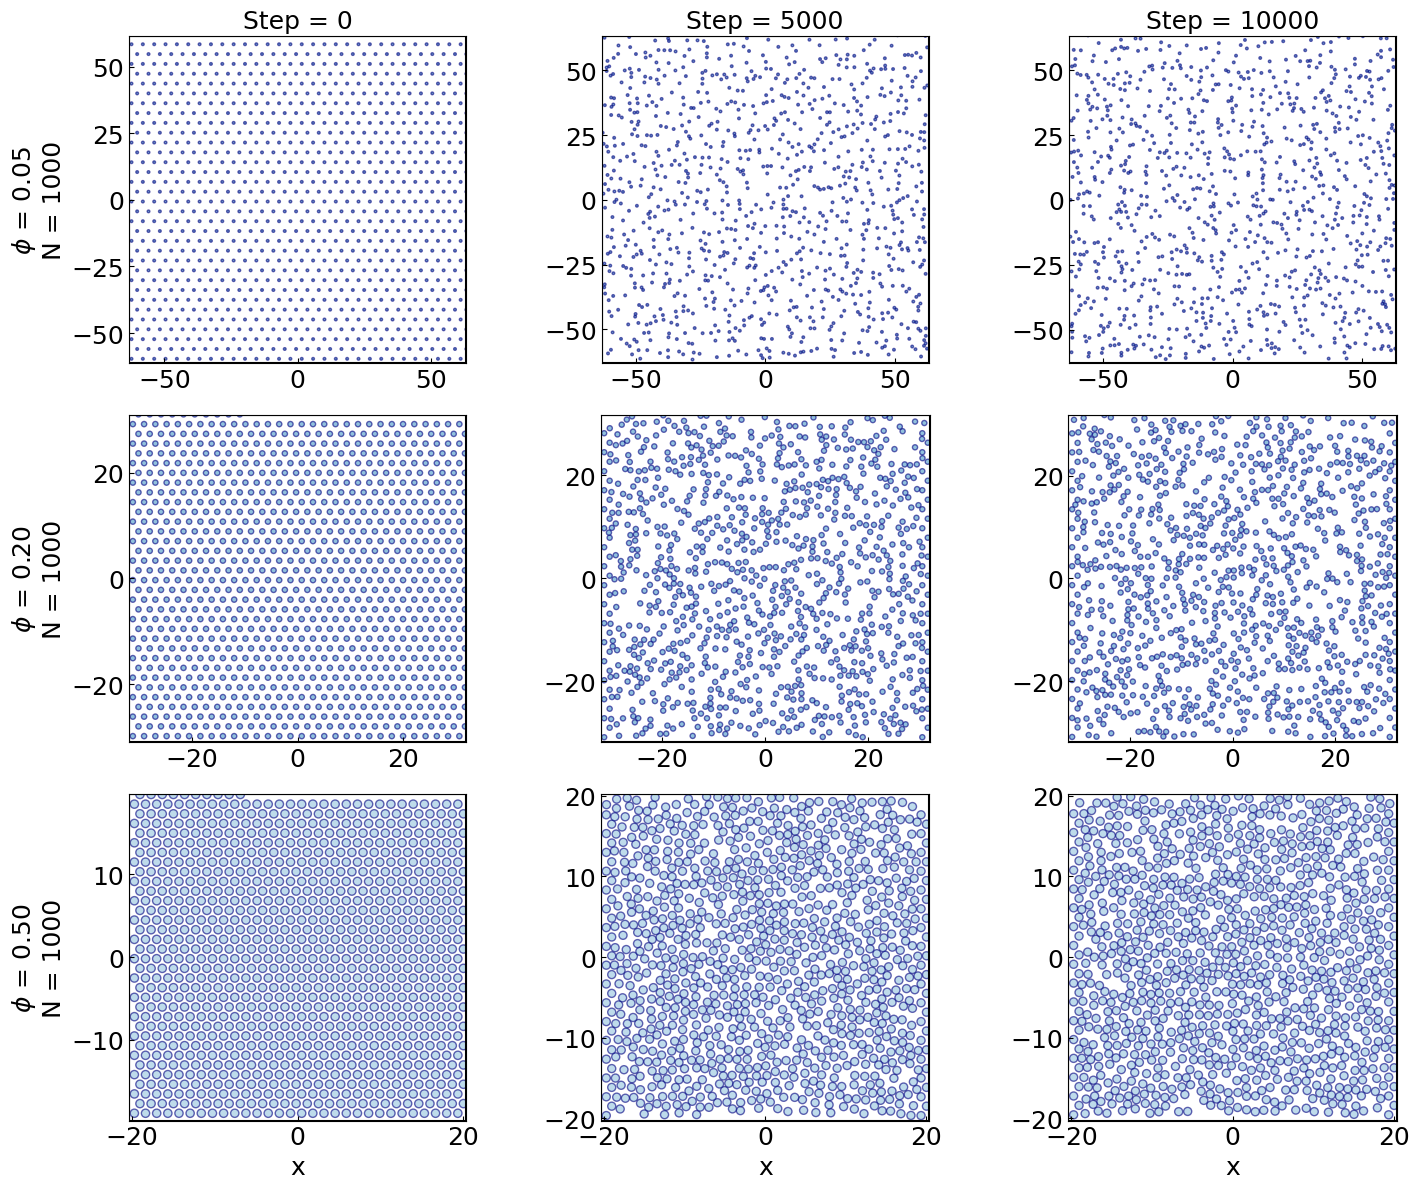

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import cm  # Para la paleta de colores

sigma = 1.0
radius = sigma / 2.0
phis = [0.05, 0.2, 0.5]         # fracciones de área
steps = [0, 5000, 10000]        # pasos que quieres visualizar

# Paleta de colores en tonos azules (azul oscuro → claro)
colors = cm.Blues_r(np.linspace(0.2, 0.6, len(phis)))

fig, axes = plt.subplots(len(phis), len(steps), figsize=(15, 12), sharex=False, sharey=False)

for i, phi in enumerate(phis):
    color = colors[i]
    for j, step in enumerate(steps):
        ax = axes[i, j]
        fname = f"phi_{phi:.2f}_step_{step}.txt"
        data = np.loadtxt(fname)
        x, y = data[:, 0], data[:, 1]

        # Recentrar coordenadas para que vayan de -L/2 a L/2
        Lx = np.max(x) - np.min(x) + 2 * radius
        Ly = np.max(y) - np.min(y) + 2 * radius
        x = x - np.mean(x)
        y = y - np.mean(y)

        ax.set_aspect('equal')

        # Dibujar partículas con color dependiente de φ
        patches = [Circle((xi, yi), radius) for xi, yi in zip(x, y)]
        collection = PatchCollection(patches, facecolor=color, edgecolor='navy', alpha=0.6)
        ax.add_collection(collection)

        # Límites centrados
        ax.set_xlim(-Lx / 2, Lx / 2)
        ax.set_ylim(-Ly / 2, Ly / 2)

        # Dibujar contorno de la caja
        ax.plot(
            [-Lx / 2, Lx / 2, Lx / 2, -Lx / 2, -Lx / 2],
            [-Ly / 2, -Ly / 2, Ly / 2, Ly / 2, -Ly / 2],
            color='black', lw=1.5
        )

        # Títulos y etiquetas
        if i == 0:
            ax.set_title(f"Step = {step}", fontsize=18)
        if j == 0:
            ax.set_ylabel(f"$\\phi$ = {phi:.2f}\nN = {len(x)}", fontsize=18)
        if i == len(phis) - 1:
            ax.set_xlabel("x", fontsize=18)

        # Mostrar ticks y ajustar tamaño
        ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()




C:\Users\PC\AppData\Local\Temp\ipykernel_26852\1411545792.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


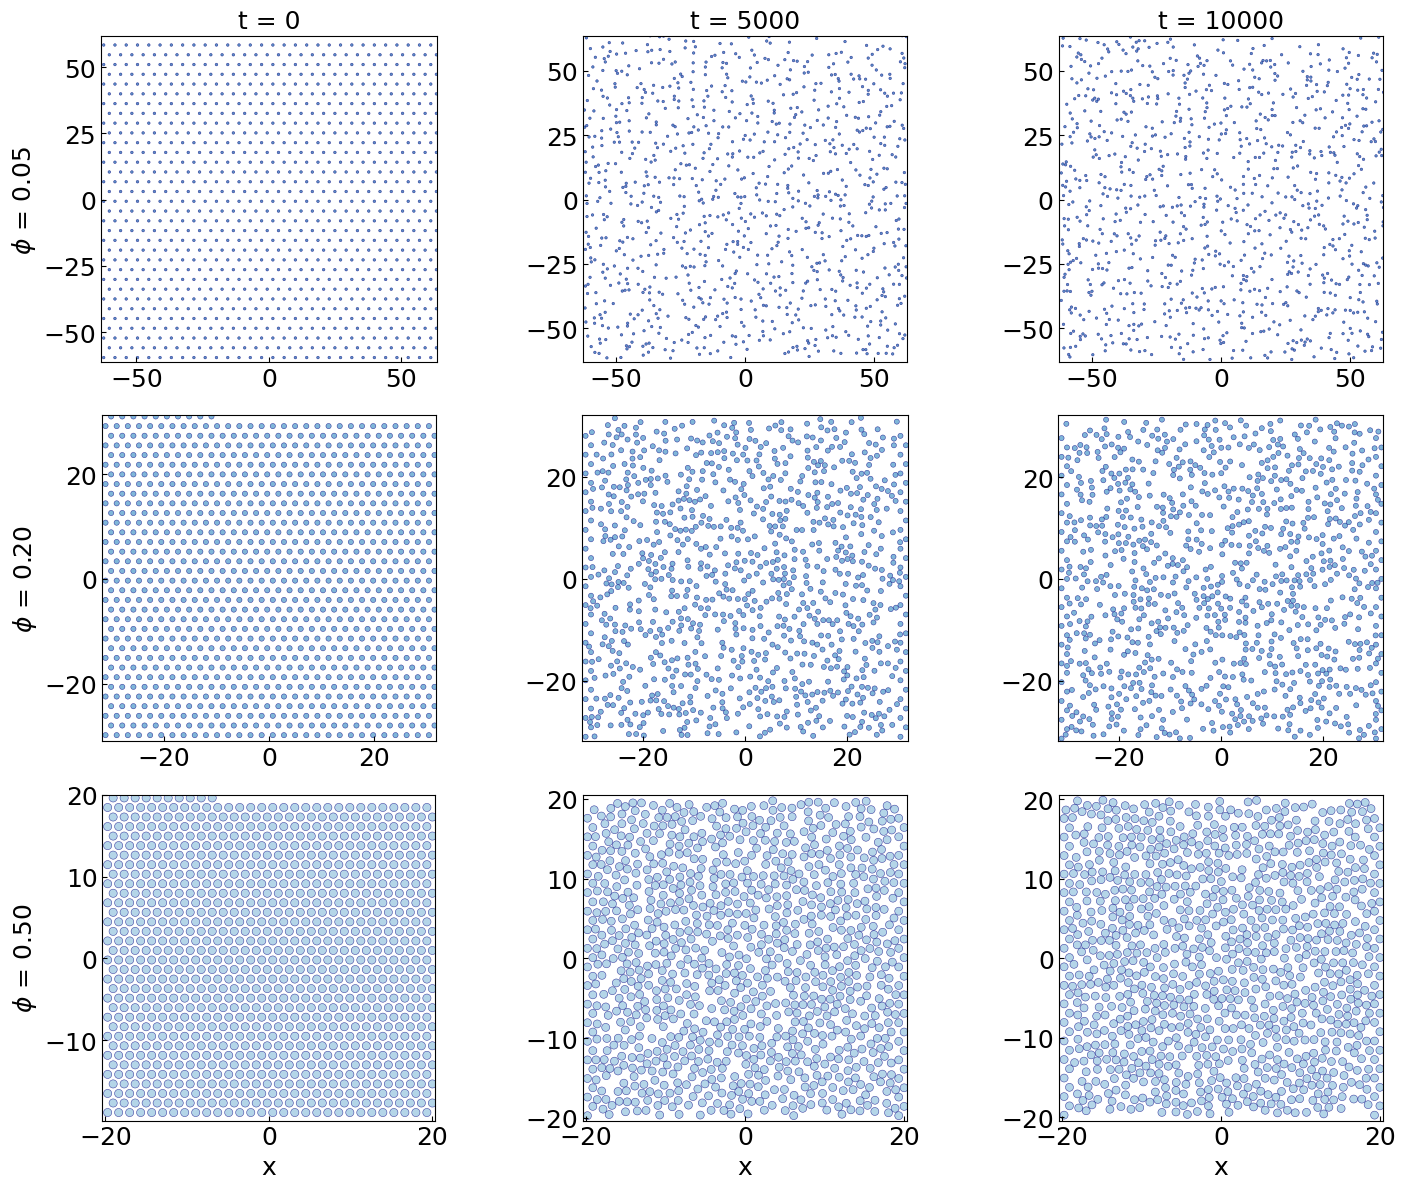

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import cm  # Para la paleta de colores

# ---------------- Configuración general ----------------
sigma = 1.0
R = sigma / 2.0
phis = [0.05, 0.2, 0.5]          # fracciones de área
steps = [0, 5000, 10000]         # pasos de tiempo
colors = cm.Blues_r(np.linspace(0.2, 0.6, len(phis)))  # tonos de azul

# ---------------- Helper para dibujar discos ----------------
def add_disks(ax, x, y, R, facecolor, edgecolor='black', lw=0.5, alpha=0.8):
    patches = [Circle((xi, yi), R) for xi, yi in zip(x, y)]
    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor,
                         linewidth=lw, alpha=alpha)
    ax.add_collection(pc)

# ---------------- Figura con subplots ----------------
fig, axes = plt.subplots(len(phis), len(steps), figsize=(15, 12), constrained_layout=True)

for i, phi in enumerate(phis):
    color = colors[i]
    for j, step in enumerate(steps):
        ax = axes[i, j]
        fname = f"phi_{phi:.2f}_step_{step}.txt"
        data = np.loadtxt(fname)
        x, y = data[:, 0], data[:, 1]

        # Centrar las coordenadas en el origen
        x = x - np.mean(x)
        y = y - np.mean(y)

        # Calcular dimensiones reales de la caja
        Lx = np.max(x) - np.min(x) + 2 * R
        Ly = np.max(y) - np.min(y) + 2 * R

        # Dibujar partículas
        add_disks(ax, x, y, R, facecolor=color, edgecolor='navy', lw=0.4, alpha=0.7)

        # Ajustar límites exactos al tamaño de la caja
        ax.set_xlim(-Lx/2, Lx/2)
        ax.set_ylim(-Ly/2-0.1, Ly/2+0.3)
        ax.set_aspect('equal', adjustable='box')

        # Títulos y etiquetas
        if i == 0:
            ax.set_title(f"t = {step}", fontsize=18)
        if j == 0:
            ax.set_ylabel(f"$\\phi$ = {phi:.2f}", fontsize=18)
        if i == len(phis) - 1:
            ax.set_xlabel("x", fontsize=18)

        # Ejes y ticks
        ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig("snpashotsphi.pdf", format='pdf', bbox_inches='tight')
plt.show()



# Steps MC needed

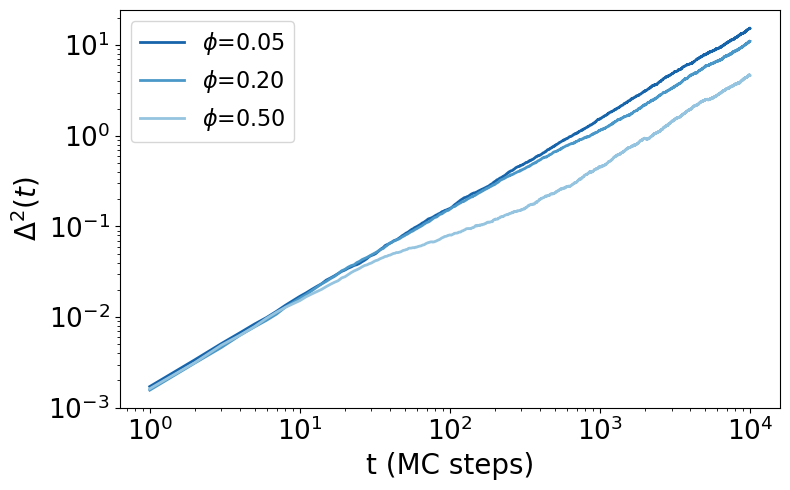

Estimated relaxation times (MC steps):
 $\phi$=0.05: 1.00e+04
 $\phi$=0.20: 1.00e+04
 $\phi$=0.50: 1.00e+04


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def load_msd(phi):
    fname = f"msd_phi_{phi:.2f}.txt"
    data = np.loadtxt(fname)
    steps = data[:,0]
    msd = data[:,1]
    return steps, msd

def estimate_relax_time(steps, msd, tol=0.05):
    ratio = msd / (steps + 1e-12)  # evitar división por cero
    for i in range(len(ratio)):
        if abs(ratio[i] - 1) < tol:
            return steps[i]
    return steps[-1]

phis = [0.05, 0.2, 0.5]
plt.figure(figsize=(8,5))

# Paleta de colores en tonos azules
colors = cm.Blues_r(np.linspace(0.2, 0.6, len(phis)))  # deltas pequeños = azul oscuro, deltas grandes = azul claro

estimates = {}
for i, phi in enumerate(phis):
    steps, msd = load_msd(phi)
    t_eq = estimate_relax_time(steps, msd, tol=0.05)
    estimates[phi] = t_eq
    plt.loglog(steps, msd, label=f"$\phi$={phi:.2f}", color=colors[i], linewidth=2)

plt.xlabel("t (MC steps)", fontsize=20)
plt.ylabel("$\Delta^2(t)$", fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.tight_layout()
plt.show()

print("Estimated relaxation times (MC steps):")
for phi, t in estimates.items():
    print(f" $\phi$={phi:.2f}: {t:.2e}")



Se ve que alcanza el equilibrio cuando entra en el regimen adecuado

# Final configuration

## 3.

Hard disks to go from a PBC box to a hard box. 
It is the same but if it crushes with a wall, that change is forbidden, so it is not accepted. 
Also, it has to be taken into account that there cannot be an overlap with the wall. 

# 5.

✅ Se encontraron 5 archivos válidos:
   snapshot_g_0.000_N=1000000.txt
   snapshot_g_0.010_N=1000000.txt
   snapshot_g_0.100_N=1000000.txt
   snapshot_g_1.000_N=1000000.txt
   snapshot_g_10.000_N=1000000.txt


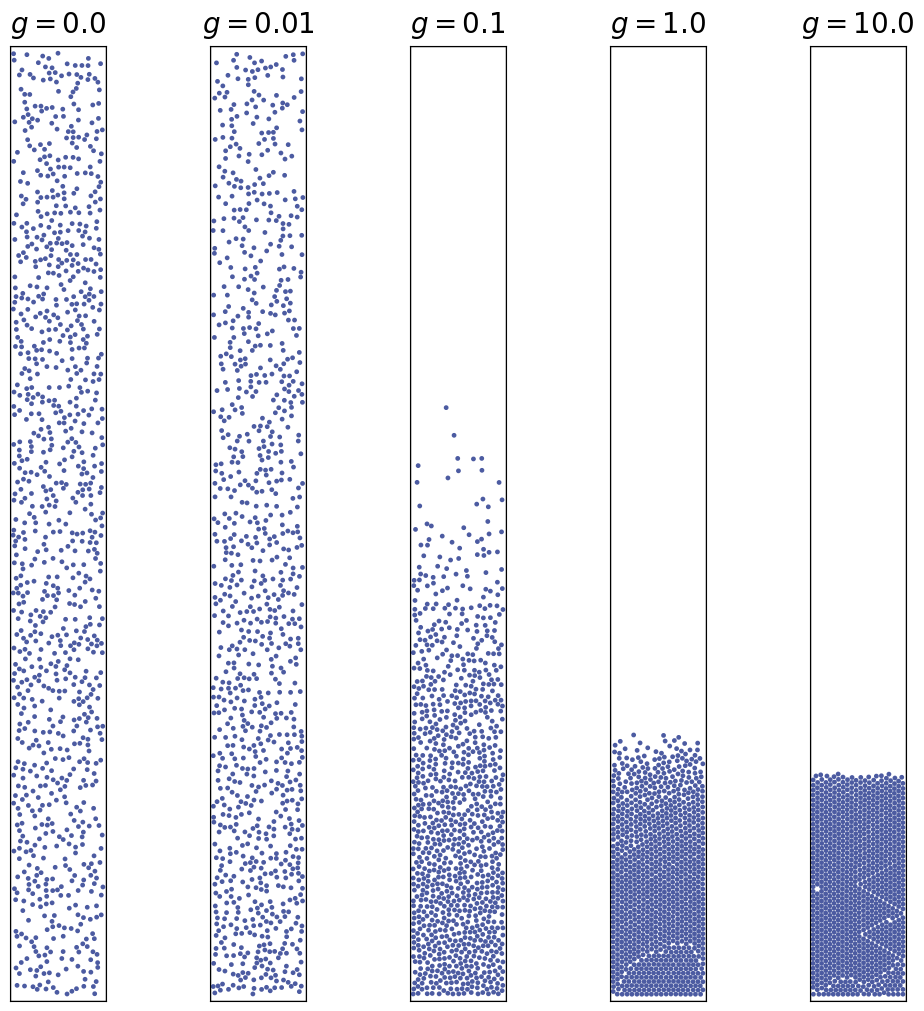

✅ Combined figure saved as 'snapshot_all_g_N.png'


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from matplotlib.patches import Circle

# --- Simulation parameters ---
Lx = 20.0
Ly = 200.0
sigma = 1.0  # particle diameter

# --- Find snapshot files that contain 'N=' ---
files = sorted(glob.glob("snapshot_g_*_N=*.txt"))
if not files:
    print("⚠️ No se encontraron archivos 'snapshot_g_*_N=*.txt' en el directorio actual.")
else:
    print(f"✅ Se encontraron {len(files)} archivos válidos:")
    for f in files:
        print("  ", f)

# --- Set up figure with subplots ---
n = len(files)
fig, axes = plt.subplots(1, n, figsize=(2*n, 10), constrained_layout=True)

# Use dark blue tone
particle_color = "#2c3e91"  # deep navy blue

for ax, fname in zip(axes, files):
    # Extract g value using regex
    match = re.search(r"snapshot_g_([0-9.]+)_N=", fname)
    if match:
        g_value = float(match.group(1))
    else:
        print(f"⚠️ No se pudo extraer g de {fname}, se omitirá.")
        continue

    # Load data
    data = np.loadtxt(fname)
    x, y = data[:, 0], data[:, 1]

    # Plot box
    rect = plt.Rectangle((-Lx/2.0, -Ly/2.0), Lx, Ly,
                         fill=False, linewidth=1.0, color='black')
    ax.add_patch(rect)

    # Plot particles
    for xi, yi in zip(x, y):
        circ = Circle((xi, yi), radius=sigma/2.0,
                      facecolor=particle_color, edgecolor='none', alpha=0.85)
        ax.add_patch(circ)

    # Set limits and appearance
    ax.set_xlim(-Lx/2.0, Lx/2.0)
    ax.set_ylim(-Ly/2.0, Ly/2.0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"$g = {g_value}$", fontsize=20, pad=10)

# --- Save and show combined figure ---
plt.savefig("snapshot_all_g_N.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Combined figure saved as 'snapshot_all_g_N.png'")
